# 1 Neural Networks
## 1.1 Visualizing the data

In [565]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

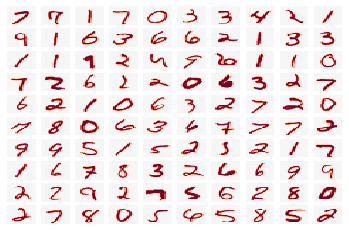

In [4]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

## =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.

# Load Training Data
path = '/Users/jonathanbaker/Documents/Coding/Coursera/ML/machine-learning-ex4/ex4/'
data = loadmat(path + 'ex4data1.mat');

X = data.get('X')
y = data.get('y').flatten()
m = X.shape[0];

# Randomly select 100 data points to display
fig, axes = plt.subplots(10, 10)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        sns.heatmap(X[np.random.randint(0, X.shape[0])].reshape([20, 20], order='F'), ax=axes[i, j]
                    , cbar=False, xticklabels=False, yticklabels=False)
        

In [1200]:
# Relabel the 10's as 0's
y[y == 10] = 0

In [1201]:
# OneHotEncode the y values
from sklearn.preprocessing import OneHotEncoder

binary_encoder = OneHotEncoder(sparse=False)
y_ = binary_encoder.fit_transform(y.reshape(-1, 1))

y_.shape

(5000, 10)

In [1202]:
binary_encoder.active_features_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [1203]:
# Use this 
y_[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Converting 10's to 0's first then OneHotEncoding has put 0 labels first (i.e. first column denotes 0), rather than 10 labels last. Need to flip the first column to the end so last column denotes 0 (0=10 in the original documentation):

N.B. This is only important when loading precalculated weights. When training NN later on, we want to return to the first column of OneHotEncoded labels to mean 0 again!

In [1204]:
y_ = np.column_stack((y_[:, 1:], y_[:, 0]))

In [1205]:
y_[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [1206]:
y_.shape

(5000, 10)

## 1.2 Model representation

In [1020]:
## ================ Part 2: Loading Parameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.
# Load the weights into variables Theta1 and Theta2

weights = loadmat(path + 'ex4weights.mat');

Theta1 = weights.get('Theta1')
Theta2 = weights.get('Theta2')


In [1021]:
Theta1.flatten().shape

(10025,)

In [1022]:
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))

In [1023]:
Theta1

array([[ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
         -1.30529929e-05,  -5.04175101e-06,   2.80464449e-09],
       [ -9.83811294e-02,   7.66168682e-09,  -9.75873689e-09, ...,
         -5.60134007e-05,   2.00940969e-07,   3.54422854e-09],
       [  1.16156052e-01,  -8.77654466e-09,   8.16037764e-09, ...,
         -1.20951657e-04,  -2.33669661e-06,  -7.50668099e-09],
       ..., 
       [ -1.83220638e-01,  -8.89272060e-09,  -9.81968100e-09, ...,
          2.35311186e-05,  -3.25484493e-06,   9.02499060e-09],
       [ -7.02096331e-01,   3.05178374e-10,   2.56061008e-09, ...,
         -8.61759744e-04,   9.43449909e-05,   3.83761998e-09],
       [ -3.50933229e-01,   8.85876862e-09,  -6.57515140e-10, ...,
         -1.80365926e-06,  -8.14464807e-06,   8.79454531e-09]])

## 1.3 Feedforward and cost function

In [1024]:
## ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#

In [1025]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

In [1026]:
def addInterceptCol(X):
    
    if len(X.shape) > 1:
        m = X.shape[0]
        
        return np.column_stack( (np.ones(m), X) )

    else:
        return np.concatenate( (np.ones(1), X) )

In [1027]:
def nnFeedForward(theta, a_in):
    """
    Calculates single layer output activations given parameters (theta) and input (a)
    """
    # Set up some useful variables    
    z_out = addInterceptCol(a_in).dot(theta.transpose())
    act_out = sigmoid(z_out)
    
    return act_out
    

In [1028]:
# Cost function without regulatization

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    NNCOSTFUNCTION Implements the neural network cost function for a two layer
    neural network which performs classification
       J = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, X, y, lambda) 
       computes the cost and gradient of the neural network. The
       parameters for the neural network are "unrolled" into the vector
       nn_params and need to be converted back into the weight matrices. 
    
       The returned parameter grad should be a "unrolled" vector of the
       partial derivatives of the neural network.
       
       Note: Unlike Andrew Ng's implementation, the y input needs to be one hot encoded labels!
    """
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[0:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1))
    
    # Set up some useful variables
    m = X.shape[0]
    
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in ex4.m
    act1 = nnFeedForward(Theta1, X)
    act2 = nnFeedForward(Theta2, act1)
    y_hat = act2
    
    J = - (  np.sum(y * np.log(y_hat)) + np.sum((1-y) * np.log(1 - y_hat))  ) / m
    
    return J

In [1029]:
# Weight regularization parameter (we set this to 0 here).
Lambda = 0;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);

print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('(this value should be about 0.287629)\n');


Cost at parameters (loaded from ex4weights): 0.28762916516131887
(this value should be about 0.287629)



In [1030]:
## =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.

In [1031]:
# Cost function with regularization

def nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    NNCOSTFUNCTION Implements the neural network cost function for a two layer
    neural network which performs classification
       J = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, X, y, lambda) 
       computes the cost and gradient of the neural network. The
       parameters for the neural network are "unrolled" into the vector
       nn_params and need to be converted back into the weight matrices. 
    
       The returned parameter grad should be a "unrolled" vector of the
       partial derivatives of the neural network.
       
       Note: Unlike Andrew Ng's implementation, the y input needs to be one hot encoded labels!

    """
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[0:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1))
    
    # Set up some useful variables
    m = X.shape[0]
    
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in ex4.m
    act1 = nnFeedForward(Theta1, X)
    act2 = nnFeedForward(Theta2, act1)
    
    y_hat = act2

    reg = Lambda * np.sum([np.sum(Theta1[:, 1:]**2), np.sum(Theta2[:, 1:]**2)]) / (2*m)
    
    J = - (  np.sum(y * np.log(y_hat)) + np.sum((1-y) * np.log(1 - y_hat))  ) / m + reg
    
    return J

In [1032]:
print('Checking Cost Function (with Regularization)... \n')

# Weight regularization parameter (we set this to 1 here).
Lambda = 1;

J = nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);

print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('(this value should be about 0.383770)\n');

Checking Cost Function (with Regularization)... 

Cost at parameters (loaded from ex4weights): 0.3837698590909236
(this value should be about 0.383770)



# 2 Backpropagation
## 2.1 Sigmoid Gradient

In [1033]:
## ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.
#

In [1034]:
def sigmoidGradient(z):
    """    
        SIGMOIDGRADIENT returns the gradient of the sigmoid function
        evaluated at z
        g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
        evaluated at z. This should work regardless if z is a matrix or a
        vector. In particular, if z is a vector or matrix, you should return
        the gradient for each element.
    """

    # Compute the gradient of the sigmoid function evaluated at
    # each value of z (z can be a matrix, vector or scalar).

    return sigmoid(z) * (1 - sigmoid(z))


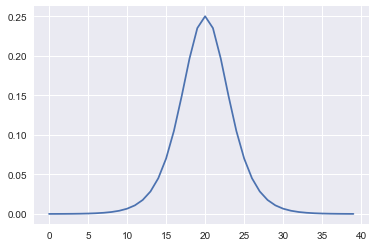

In [1035]:
plt.plot(sigmoidGradient(np.arange(-10, 10, 0.5)))

In [1036]:
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:');
sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:


array([ 0.19661193,  0.23500371,  0.25      ,  0.23500371,  0.19661193])

## 2.2 Random Initialization

In [1037]:
## ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

In [1038]:
def randInitializeWeights(L_in, L_out):
    
    return np.random.uniform(-0.12, 0.12, size=(L_in + 1)* L_out).reshape((L_in + 1), L_out)

In [1039]:
randInitializeWeights(1, 2)

array([[ 0.00328659,  0.02338076],
       [ 0.01875905, -0.04584857]])

In [1040]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()));

## 2.3 Backpropagation

In [1041]:
## =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.
#

In [1042]:
def nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    
    Theta1 = nn_params[0:(input_layer_size + 1) * hidden_layer_size].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape((num_labels, hidden_layer_size + 1))
    m = X.shape[0]
    #return Theta1
    
    # Create mask for Lambda multiplication later. Bias terms arent regularised
    mask1 = Theta1.copy() # n.b. must copy here or else will set Theta1[0] column to zeros
    mask2 = Theta2.copy() # n.b. must copy here or else will set Theta2[0] column to zeros
    mask1[:, 0] = 0
    mask2[:, 0] = 0
    mask = np.concatenate((mask1.flatten(), mask2.flatten()))
    #return mask

    # Create empty gradient matrices
    Theta1_grad = np.zeros(Theta1.shape) # This was incorrect: (input_layer_size, hidden_layer_size))
    Theta2_grad = np.zeros(Theta2.shape) # This was incorrect: (hidden_layer_size, num_labels))
    #return Theta1_grad.shape
    
    # Feedforward:   
    a1 = addInterceptCol(X)
    
    z2 = a1.dot(Theta1.transpose())
    a2 = sigmoid(z2)
    a2 = addInterceptCol(a2)
    
    z3 = a2.dot(Theta2.transpose())
    a3 = sigmoid(z3)

    delta3 = a3 - y
    delta2 = delta3.dot(Theta2[:, 1:]) * sigmoidGradient(z2) # careful of slicing placement. Slicing weights
    
    # Taking dot product faster than looping through all m training examples
    Theta1_grad = Theta1_grad + delta2.transpose().dot(a1)
    Theta2_grad = Theta2_grad + delta3.transpose().dot(a2)
    
    grad = (np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()]) + Lambda * mask ) / m
    
    return grad

In [1043]:
nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, 0)

array([  6.18712766e-05,   0.00000000e+00,   0.00000000e+00, ...,
         9.66104721e-05,  -7.57736846e-04,   7.73329872e-04])

In [1044]:
nnFeedForward(Theta2, nnFeedForward(Theta1, X)).shape

(5000, 10)

In [1045]:
def debugInitializeWeights(fan_out, fan_in):
    """    
    DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    incoming connections and fan_out outgoing connections using a fixed
    strategy, this will help you later in debugging
       W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
       of a layer with fan_in incoming connections and fan_out outgoing 
       connections using a fix set of values
    
       Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
       the first row of W handles the "bias" terms
    """

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in));

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.sin(np.arange(1, W.size+1)).reshape(W.shape) / 10;

    # =========================================================================

    return W

In [1046]:
debugInitializeWeights(3,3)

array([[ 0.0841471 ,  0.09092974,  0.014112  , -0.07568025],
       [-0.09589243, -0.02794155,  0.06569866,  0.09893582],
       [ 0.04121185, -0.05440211, -0.09999902, -0.05365729]])

In [1047]:
def computeNumericalGradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
        COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
        and gives us a numerical estimate of the gradient.
        numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
        gradient of the function J around theta. Calling y = J(theta) should
        return the function value at theta.

     Notes: The following code implements numerical gradient checking, and 
            returns the numerical gradient.It sets numgrad(i) to (a numerical 
            approximation of) the partial derivative of J with respect to the 
            i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
            be the (approximately) the partial derivative of J with respect 
            to theta(i).)    
    """           

    numgrad = np.zeros(theta.size);
    perturb = np.zeros(theta.size);
    e = 1e-4;
    for p in range(theta.size):
        # Set perturbation vector
        perturb[p] = e;
        loss1 = nnCostFunctionReg(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda);
        loss2 = nnCostFunctionReg(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        perturb[p] = 0;

    return numgrad


In [1048]:
def checkNNGradients(Lambda=0):
    """
    CHECKNNGRADIENTS Creates a small neural network to check the
    backpropagation gradients
       CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
       backpropagation gradients, it will output the analytical gradients
       produced by your backprop code and the numerical gradients (computed
       using computeNumericalGradient). These two gradient computations should
       result in very similar values.
    """

    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
    #return Theta1, Theta2
    
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1);
    y  = 1 + np.mod(np.arange(1, m+1), num_labels).transpose();
    #return X, y

    # Bit of hack to make the code work. OneHotEncode y here
    from sklearn.preprocessing import OneHotEncoder
    binary_encoder = OneHotEncoder(sparse=False)
    y_ = binary_encoder.fit_transform(y.reshape(-1, 1))

    # Unroll parameters
    nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()));
    #return nn_params # Debugging
    
    # Cost function  
    cost = nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    grad = nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    numgrad = computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    #return numgrad.shape, grad.shape # Debugging
    
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print(np.column_stack((numgrad, grad)));
    print('The above two columns you get should be very similar.\n' \
            '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n');

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    # Note octave norm is Euclidean distance (p=2 norm)
    diff = np.linalg.norm(numgrad-grad, 2)/np.linalg.norm(numgrad+grad, 2);

    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {}\n'.format(diff));



In [1049]:
print('\nChecking Backpropagation... \n');

#  Check gradients by running checkNNGradients
#tmp1, tmp2 = checkNNGradients() # Debug
checkNNGradients()


Checking Backpropagation... 

[[  1.23162247e-02   1.23162247e-02]
 [  1.73828185e-04   1.73828184e-04]
 [  2.61455142e-04   2.61455144e-04]
 [  1.08701450e-04   1.08701450e-04]
 [  3.92471368e-03   3.92471369e-03]
 [  1.90101255e-04   1.90101252e-04]
 [  2.22272329e-04   2.22272331e-04]
 [  5.00872543e-05   5.00872547e-05]
 [ -8.08459406e-03  -8.08459407e-03]
 [  3.13170601e-05   3.13170587e-05]
 [ -2.17840368e-05  -2.17840341e-05]
 [ -5.48569856e-05  -5.48569864e-05]
 [ -1.26669105e-02  -1.26669105e-02]
 [ -1.56130211e-04  -1.56130210e-04]
 [ -2.45506164e-04  -2.45506163e-04]
 [ -1.09164882e-04  -1.09164881e-04]
 [ -5.59342546e-03  -5.59342547e-03]
 [ -2.00036570e-04  -2.00036572e-04]
 [ -2.43630223e-04  -2.43630220e-04]
 [ -6.32313690e-05  -6.32313673e-05]
 [  3.09347722e-01   3.09347722e-01]
 [  1.61067138e-01   1.61067138e-01]
 [  1.47036522e-01   1.47036522e-01]
 [  1.58268577e-01   1.58268577e-01]
 [  1.57616707e-01   1.57616707e-01]
 [  1.47236360e-01   1.47236360e-01]
 [  1.0

## 2.5 Regularized Neural Networks

In [1050]:
## =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.

In [1051]:
print('\nChecking Backpropagation (w/ Regularization) ... \n')

#  Check gradients by running checkNNGradients
Lambda = 3;
checkNNGradients(Lambda);

# Also output the costFunction debugging values
debug_J  = nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);

print('\n\nCost at (fixed) debugging parameters (w/ lambda = {}): {} ' \
         '\n(for lambda = 3, this value should be about 0.576051)\n\n'.format(Lambda, debug_J));



Checking Backpropagation (w/ Regularization) ... 

[[ 0.01231622  0.01231622]
 [ 0.05473167  0.05473167]
 [ 0.00872866  0.00872866]
 [-0.04529945 -0.04529945]
 [ 0.00392471  0.00392471]
 [-0.01657483 -0.01657483]
 [ 0.03964147  0.03964147]
 [ 0.05941158  0.05941158]
 [-0.00808459 -0.00808459]
 [-0.03260995 -0.03260995]
 [-0.0600212  -0.0600212 ]
 [-0.03224923 -0.03224923]
 [-0.01266691 -0.01266691]
 [ 0.05928031  0.05928031]
 [ 0.03877176  0.03877176]
 [-0.01738336 -0.01738336]
 [-0.00559343 -0.00559343]
 [-0.04525927 -0.04525927]
 [ 0.008749    0.008749  ]
 [ 0.05471348  0.05471348]
 [ 0.30934772  0.30934772]
 [ 0.21562498  0.21562498]
 [ 0.15550372  0.15550372]
 [ 0.11286043  0.11286043]
 [ 0.10008125  0.10008125]
 [ 0.13047143  0.13047143]
 [ 0.108133    0.108133  ]
 [ 0.11552487  0.11552487]
 [ 0.07667816  0.07667816]
 [ 0.02209407  0.02209407]
 [-0.00469114 -0.00469114]
 [ 0.01958089  0.01958089]
 [ 0.10627037  0.10627037]
 [ 0.11519755  0.11519755]
 [ 0.08957408  0.08957408]
 [ 

## 2.6 Learning parameters using fmincg

In [1207]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin
from scipy.optimize import fmin_cg
from scipy.optimize import minimize

In [1211]:
## =================== Part 8: Training NN ===================
#  You have now implemented all the code necessary to train a neural 
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.

print('Training Neural Network... ')

#  After you have completed the assignment, change the iterations itns to a larger
#  value to see how more training helps.
itns = 50

#  You should also try different values of lambda
Lambda = 1

# Optimize for nnCostFunction
opt_nn_params = fmin_cg(f=nnCostFunctionReg
                    , x0=initial_nn_params
                    , fprime = nnGradients # Without this the optimization is xx. slow
                    , args=(input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda)
                    , maxiter=itns);

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = opt_nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1));
Theta2 = opt_nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1));

Training Neural Network... 
         Current function value: 0.437494
         Iterations: 50
         Function evaluations: 113
         Gradient evaluations: 113


In [1212]:
Theta1[1, 1:].shape

(400,)

# 3 Visualising the hidden layer

Visualizing Neural Network...


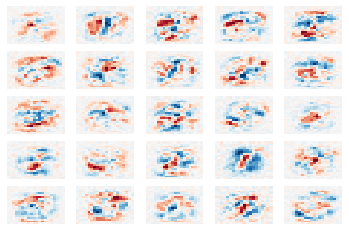

In [1213]:
## ================= Part 9: Visualize Weights =================
#  You can now "visualize" what the neural network is learning by 
#  displaying the hidden units to see what features they are capturing in 
#  the data.

print('Visualizing Neural Network...')

counter = 0

fig, axes = plt.subplots(5, 5)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        sns.heatmap(Theta1[counter, 1:].reshape([20, 20], order='F'), ax=axes[i, j]
                    , cbar=False, xticklabels=False, yticklabels=False)
        
        counter += 1


In [1214]:
def predict(Theta1, Theta2, X):
    """
    PREDICT Predict the label of an input given a trained neural network
       p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
       trained weights of a neural network (Theta1, Theta2)
    """
    
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)

    h1 = sigmoid(addInterceptCol(X).dot(Theta1.transpose()));
    h2 = sigmoid(addInterceptCol(h1).dot(Theta2.transpose()));
    
    # need to fix for 1 indexed to column 0, 2 indexed to col 1, ... , 0 indexed to column 9
    y_hat = np.column_stack((h2[:, -1], h2[:, :-1]))
    p = pd.DataFrame(y_hat).idxmax(1) 

    return p

In [1215]:
## ================= Part 10: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);

print('\nTraining Set Accuracy: {}\n'.format(np.mean(np.double(pred == y) * 100)));



Training Set Accuracy: 96.9



In [1216]:
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [1217]:
np.array(pred)

array([0, 0, 0, ..., 9, 9, 9])

## 3.1 Optional (ungraded) exercise

#### Try overfitting (low regulatization, many iterations)

In [1218]:
print('Training Neural Network... ')

#  After you have completed the assignment, change the iterations itns to a larger
#  value to see how more training helps.
itns = 200

#  You should also try different values of lambda
Lambda = 0

# Optimize for nnCostFunction
opt_nn_params = fmin_cg(f=nnCostFunctionReg
                    , x0=initial_nn_params
                    , fprime = nnGradients # Without this the optimization is xx. slow
                    , args=(input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda)
                    , maxiter=itns);

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = opt_nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1));
Theta2 = opt_nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1));

Training Neural Network... 
         Current function value: 0.002617
         Iterations: 200
         Function evaluations: 607
         Gradient evaluations: 607


Visualizing Neural Network...


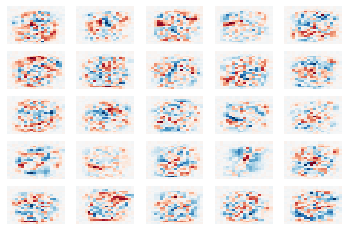

In [1219]:
print('Visualizing Neural Network...')

counter = 0

fig, axes = plt.subplots(5, 5)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        sns.heatmap(Theta1[counter, 1:].reshape([20, 20], order='F'), ax=axes[i, j]
                    , cbar=False, xticklabels=False, yticklabels=False)
        
        counter += 1


In [1220]:

pred = predict(Theta1, Theta2, X);

print('Training Set Accuracy: {}'.format(np.mean(np.double(pred == y) * 100)));


Training Set Accuracy: 100.0


Yep, looks overfit!

#### Try underfitting (high regulatization, few iterations)

In [1221]:
print('Training Neural Network... ')

#  After you have completed the assignment, change the iterations itns to a larger
#  value to see how more training helps.
itns = 20

#  You should also try different values of lambda
Lambda = 10

# Optimize for nnCostFunction
opt_nn_params = fmin_cg(f=nnCostFunctionReg
                    , x0=initial_nn_params
                    , fprime = nnGradients # Without this the optimization is xx. slow
                    , args=(input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda)
                    , maxiter=itns);

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = opt_nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1));
Theta2 = opt_nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1));

Training Neural Network... 
         Current function value: 1.308037
         Iterations: 20
         Function evaluations: 42
         Gradient evaluations: 42


Visualizing Neural Network...


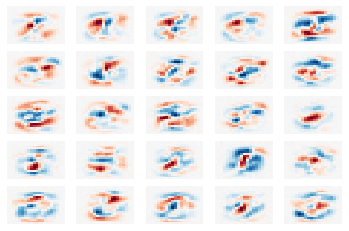

In [1222]:
print('Visualizing Neural Network...')

counter = 0

fig, axes = plt.subplots(5, 5)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        sns.heatmap(Theta1[counter, 1:].reshape([20, 20], order='F'), ax=axes[i, j]
                    , cbar=False, xticklabels=False, yticklabels=False)
        
        counter += 1


In [1223]:

pred = predict(Theta1, Theta2, X);

print('Training Set Accuracy: {}'.format(np.mean(np.double(pred == y) * 100)));


Training Set Accuracy: 90.92
